In [7]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
from MyCode.lawsuit import utils
import graphviz
import multiprocessing
from concurrent.futures import ThreadPoolExecutor
import ast

In [8]:
pd.set_option('max_columns', None)
FILE_NAME = "test"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("../dataset_perso/Lawsuit.csv")
del df['ID']

salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)

for i in range(0,len(df)):
    df.at[i, "Gender"] = 0 if df.at[i, "Gender"] == 1 else 1
    X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]

y = df['Salary_mean']
sensitive = df['Gender']
print(utils.discrimination(y, sensitive))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

0.31205112598904444


accuracy_pred = 0.89952153
accuracy_test = 0.82692308
discrimination_train = 0.32561905
discrimination_train_pred = 0.29304762
sum discrimination_pred  = 0.29304762
sum discrimination_pred abs = 0.32466667


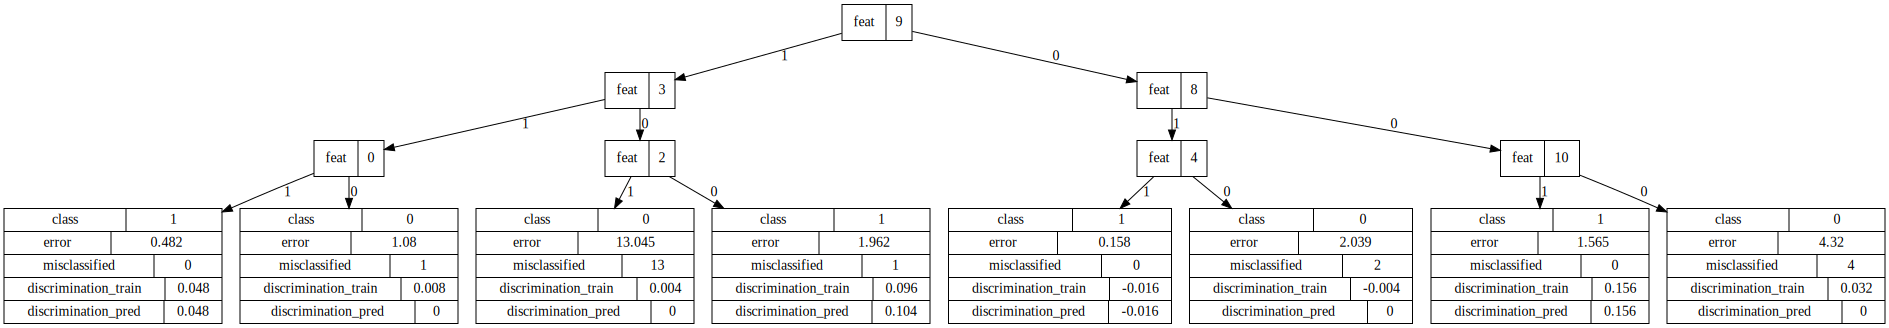

In [9]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

print(f'sum discrimination_pred  = {round(sum_discrimination_additive_train_pred, 8)}')
print(f'sum discrimination_pred abs = {round(sum_discrimination_additive_train_pred_abs, 8)}')

dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)

Path: ((9, 'left'), (3, 'right'), (2, 'left')) 
accuracy: -0.02870813397129187 
discrimination: -0.08238095238095242 
ratio: 2.8696031746031756 
contigency: 
[0.05741626794258373, 0.023923444976076555]
[0.03349282296650718, 0.03827751196172249]
Path: ((9, 'left'), (3, 'right'), (2, 'right')) 
accuracy: -0.07655502392344497 
discrimination: -0.1041904761904762 
ratio: 1.3609880952380953 
contigency: 
[0.0, 0.009569377990430622]
[0.004784688995215311, 0.07177033492822966]
accuracy_pred = 0.79425837
accuracy_test = 0.80769231
discrimination_train = 0.32561905
discrimination_train_pred = 0.10647619
sum discrimination_pred  = 0.10647619
sum discrimination_pred abs = 0.30285714


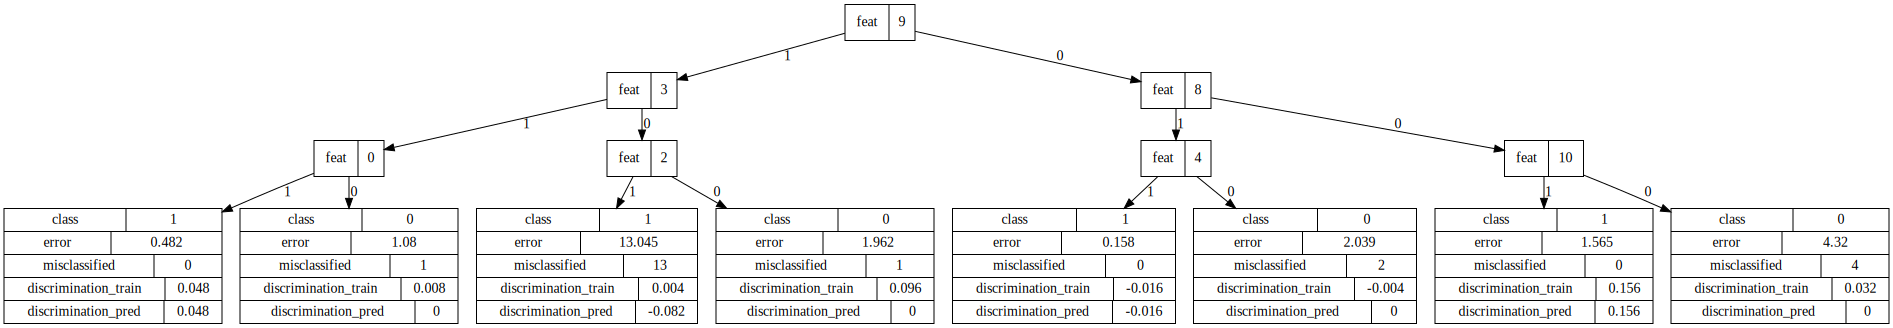

In [10]:
from MyCode import relabeling_pydl

leafs_relab = relabeling_pydl.relab_leaf_limit(clf.tree_, y_train, y_pred_train, sensitive_train, 2)
sum_acc = 0
sum_disc = 0
for leaf in leafs_relab:
    print(leaf)
    relabeling_pydl.browse_and_relab(clf.tree_, list(leaf.path), leaf)
    sum_acc += leaf.acc
    sum_disc += leaf.disc

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

print(f'sum discrimination_pred  = {round(sum_discrimination_additive_train_pred, 8)}')
print(f'sum discrimination_pred abs = {round(sum_discrimination_additive_train_pred_abs, 8)}')

dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)

In [11]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.misclassified(list(tids), y_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
y_pred_train = clf.predict(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
print(f'accuracy_pred = {round(accuracy_score(y_train, y_pred_train), 8)}')
print(f'accuracy_test = {round(accuracy_score(y_test, y_pred_test), 8)}')
print(f'discrimination_train = {round(utils.discrimination(y_train, sensitive_train), 8)}')
print(f'discrimination_train_pred = {round(utils.discrimination(y_pred_train, sensitive_train), 8)}')

utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
utils.sum_elem_tree(clf.tree_, "misclassified")

accuracy_pred = 0.89952153
accuracy_test = 0.80769231
discrimination_train = 0.32561905
discrimination_train_pred = 0.27704762


21

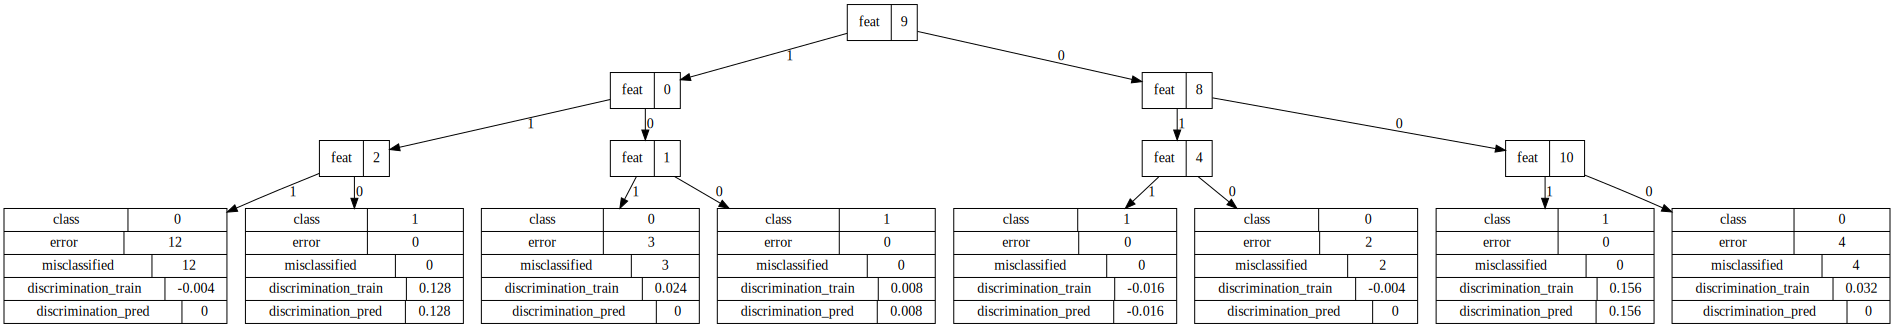

In [12]:
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)